# CNN Waste Classification

## Introduction

Purpose, goal, context, blah blah blah

## Data Pre-Processing

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install torch -- uncomment first time you run
import seaborn as sns
#!pip install torch -- uncomment first time you run
import torch
#!pip install torchvision -- uncomment first time you run
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder

In [11]:
# Define set of transformations- convert image to PyTorch tensor, scale pixels from 0-255 to 0.0 - 1.0, normalizes pixels to -1.0 - 1.0
# Output is a (3, 256, 256) array --> Color channels 0.0 - 1.0 and the dimensions 256x256
transform_scratch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [12]:
# Load in the dataset and apply the transform
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder(root="images/", transform=transform_scratch)
print(f"Total images: {len(full_dataset)}") # Print number of images
print(f"Class labels: {full_dataset.classes}") # Print all of the class labels

Total images: 15000
Class labels: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


## Define Data Splits

-- **NOTES** --

Here we can mess around with different training splits such as 
- Random split
- Evenly divide each sub-category (Stratified)
- Evenly divide each sub-category AND default/real world images (Double Stratified)
- Train more on default images, test more on real world (Studio Train)

All of these are implemented below. Maybe we start with either random or double stratified but can test out all going forward.

In [4]:
from torch.utils.data import random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

import numpy as np

# Set the split sizes
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size) # TRAIN proportion = 0.7
val_size = int(0.15 * dataset_size) # VALIDATION proportion = 0.15
test_size = dataset_size - train_size - val_size  # TEST proportion = 0.15

##### RANDOMLY split the dataset #####
random_train_dataset, random_val_dataset, random_test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Random Train size: {len(random_train_dataset)}")
print(f"Random Validation size: {len(random_val_dataset)}")
print(f"Random Test size: {len(random_test_dataset)}\n")

##### STRATIFIED SPLIT (Evenly distribute each category between the train, val, test proportions) #####
## Get all targets from the dataset
targets = np.array(full_dataset.targets)

# 1st split: Separate 70% training data and 30% temp (which will become val + test)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(np.zeros(len(targets)), targets))

# Use class labels from the temp split to do a second stratified split (val and test)
temp_targets = targets[temp_idx]

# 2nd split: Split the 30% temp into 15% val and 15% test
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter2.split(np.zeros(len(temp_idx)), temp_targets))

# Since val/test indices refer to the temp set, map them back to the full dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create PyTorch Subset objects for each split, using the final indices
strat_train_dataset = Subset(full_dataset, train_idx)
strat_val_dataset = Subset(full_dataset, val_idx)
strat_test_dataset = Subset(full_dataset, test_idx)

# Print sizes again
print(f"Stratified Train size: {len(strat_train_dataset)}")
print(f"Stratified Validation size: {len(strat_val_dataset)}")
print(f"Stratified Test size: {len(strat_test_dataset)}\n")

##### DOUBLE STRATIFIED SPLIT (Evenly distribute each category and real world vs default between train/val/test) #####
# Step 1: Create a list of full file paths for all images
all_paths = [full_dataset.samples[i][0] for i in range(len(full_dataset))]

# Step 2: Create a combined stratification label for each image: e.g., "plastic_water_bottles__default"
combined_labels = []
for path in all_paths:
    # Example path: images/plastic_water_bottles/default/image1.png
    parts = path.split(os.sep)
    category = parts[-3]  # e.g., plastic_water_bottles
    subtype = parts[-2]   # e.g., default or real_world
    combined_label = f"{category}__{subtype}"
    combined_labels.append(combined_label)

combined_labels = np.array(combined_labels)

# Step 3: First split: 70% train, 30% temp (val + test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(split1.split(np.zeros(len(combined_labels)), combined_labels))

# Step 4: Second split: split temp into 50% val, 50% test (i.e., 15% each overall)
temp_labels = combined_labels[temp_idx]
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(split2.split(np.zeros(len(temp_labels)), temp_labels))

# Map relative val/test indices back to full dataset indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

# Step 5: Create PyTorch Subsets
double_strat_train_dataset = Subset(full_dataset, train_idx)
double_strat_val_dataset = Subset(full_dataset, val_idx)
double_strat_test_dataset = Subset(full_dataset, test_idx)

# Optional sanity check
print(f"Double Stratified Train size: {len(double_strat_train_dataset)}")
print(f"Double Stratified Validation size: {len(double_strat_val_dataset)}")
print(f"Double Stratified Test size: {len(double_strat_test_dataset)}\n")

##### DEFAULT v REAL WORLD TRAIN SPLIT (All default goes to train, real_world fills in remaining train, then val & test) #####
# Map: class index → class name (e.g., 0 → 'plastic_water_bottles')
# Map class index → class name (e.g., 0 → 'plastic_water_bottles')
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Split default and real_world
default_indices = []
realworld_indices = []

for i, (path, class_idx) in enumerate(full_dataset.samples):
    subtype = path.split(os.sep)[-2]  # 'default' or 'real_world'
    if subtype == "default":
        default_indices.append(i)
    elif subtype == "real_world":
        realworld_indices.append(i)

# Calculate dataset sizes
total_size = len(full_dataset)
target_train_size = int(0.7 * total_size)
target_val_size = int(0.15 * total_size)
target_test_size = total_size - target_train_size - target_val_size

# Use all default images in training set
train_idx = set(default_indices)

# How many more real_world images needed for train?
remaining_needed = target_train_size - len(train_idx)

# Sanity check
if remaining_needed < 0:
    raise ValueError("Too many default images to satisfy 70% train split!")

# Convert to array
realworld_indices = np.array(realworld_indices)

# First: get required real_world images for training
rw_train_idx, rw_temp_idx = train_test_split(
    realworld_indices,
    train_size=remaining_needed,
    random_state=42,
    shuffle=True
)

# Second: split the rest equally into val and test
rw_val_idx, rw_test_idx = train_test_split(
    rw_temp_idx,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

# Final index sets
train_idx.update(rw_train_idx)
val_idx = set(rw_val_idx)
test_idx = set(rw_test_idx)

# Create subsets
drw_train_dataset = Subset(full_dataset, sorted(train_idx))
drw_val_dataset = Subset(full_dataset, sorted(val_idx))
drw_test_dataset = Subset(full_dataset, sorted(test_idx))

# Print final sizes
print(f"DRW Train size: {len(drw_train_dataset)}")
print(f"DRW Validation size: {len(drw_val_dataset)}")
print(f"DRW Test size: {len(drw_test_dataset)}")

Random Train size: 10500
Random Validation size: 2250
Random Test size: 2250

Stratified Train size: 10500
Stratified Validation size: 2250
Stratified Test size: 2250

Double Stratified Train size: 10500
Double Stratified Validation size: 2250
Double Stratified Test size: 2250

DRW Train size: 10500
DRW Validation size: 2250
DRW Test size: 2250


### Implement Data Loader

In [5]:
from torch.utils.data import DataLoader

# Use data loader to improve efficiency of loading data during training
batch_size = 32  # Can be adjusted

# shuffle = True : Ensures all images from a category aren't trained on consecutively
random_train_loader = DataLoader(random_train_dataset, batch_size=batch_size, shuffle=True) 
random_val_loader = DataLoader(random_val_dataset, batch_size=batch_size, shuffle=False)
random_test_loader = DataLoader(random_test_dataset, batch_size=batch_size, shuffle=False)


double_strat_train_loader = DataLoader(double_strat_train_dataset, batch_size=batch_size, shuffle=True) 
double_strat_train_loader = DataLoader(double_strat_val_dataset, batch_size=batch_size, shuffle=False)
double_strat_train_loader = DataLoader(double_strat_test_dataset, batch_size=batch_size, shuffle=False)


##  Predict Waste Category for New Images


In [7]:
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.7 MB/s eta 0:00:00a 0:00:01


In [13]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load the Full Pretrained Model
efficientnet_model = torch.load('full_efficientnet_model_v3.pth', map_location=device)
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()

print("✅ Full EfficientNet model loaded and ready.")

# preprocessing Transform
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 5. Class Names (Fixed Order — Official Mapping from Training)
class_names = [
    'aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging',
    'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste',
    'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper',
    'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers',
    'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags',
    'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags'
]

# 6. Subcategory → Main Category Mapping (Copenhagen waste policy)
subcategory_to_main_category = {
    "disposable_plastic_cutlery": "Plastic",
    "plastic_cup_lids": "Plastic",
    "plastic_detergent_bottles": "Plastic",
    "plastic_food_containers": "Plastic",
    "plastic_shopping_bags": "Plastic",
    "plastic_soda_bottles": "Plastic",
    "plastic_straws": "Plastic",
    "plastic_trash_bags": "Plastic",
    "plastic_water_bottles": "Plastic",
    "styrofoam_cups": "Plastic",
    "styrofoam_food_containers": "Plastic",
    "aerosol_cans": "Metal",
    "aluminum_food_cans": "Metal",
    "aluminum_soda_cans": "Metal",
    "steel_food_cans": "Metal",
    "glass_beverage_bottles": "Glass",
    "glass_cosmetic_containers": "Glass",
    "glass_food_jars": "Glass",
    "cardboard_boxes": "Cardboard",
    "cardboard_packaging": "Cardboard",
    "magazines": "Paper",
    "newspaper": "Paper",
    "office_paper": "Paper",
    "coffee_grounds": "Food Waste",
    "eggshells": "Food Waste",
    "food_waste": "Food Waste",
    "tea_bags": "Food Waste",
    "shoes": "Textile Waste",
    "clothing": "Textile Waste",
    "paper_cups": "Residual Waste"  
}

# 7. Predict Function
import torch.nn.functional as F

def predict_image_with_other(image_path, confidence_threshold=0.6):
    image = Image.open(image_path).convert('RGB')
    image = predict_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = efficientnet_model(image)
        probs = F.softmax(outputs, dim=1)  
        top_prob, top_class = probs.topk(1, dim=1)  # top-1 prediction and its probability

    top_prob = top_prob.item()
    top_class = top_class.item()

    predicted_subcategory = class_names[top_class]
    predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

    # if the model isn't confident enough, override to "Other"
    if top_prob < confidence_threshold:
        predicted_subcategory = "Other"
        predicted_main_category = "Other"

    return predicted_subcategory, predicted_main_category, top_prob

# def predict_image(image_path):
#     image = Image.open(image_path).convert('RGB')
#     image = predict_transform(image).unsqueeze(0).to(device)

#     with torch.no_grad():
#         outputs = efficientnet_model(image)
#         _, preds = torch.max(outputs, 1)  # Get the top-1 prediction

#     predicted_subcategory = class_names[preds.item()]
#     predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

#     return predicted_subcategory, predicted_main_category

# test_image_path = "laptop.jpg"  

# image = Image.open(test_image_path).convert('RGB')

# plt.imshow(image)
# plt.axis('off')
# plt.title("Uploaded Image")
# plt.show()

# input_image = predict_transform(image).unsqueeze(0).to(device)

# with torch.no_grad():
#     outputs = efficientnet_model(input_image)
#     _, preds = torch.max(outputs, 1)

# predicted_subcategory = class_names[preds.item()]
# predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

# print(f" Predicted Subcategory: {predicted_subcategory}")
# print(f" Predicted Main Category: {predicted_main_category}")

✅ Full EfficientNet model loaded and ready.


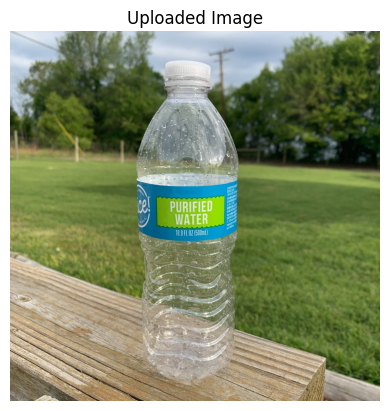

🗑️ Predicted Subcategory: plastic_water_bottles
♻️ Predicted Main Category: Plastic


In [9]:
# ======================================
# Water Bottle
# ======================================
import matplotlib.pyplot as plt

test_image_path = "waterbottle.jpg"  

image = Image.open(test_image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

input_image = predict_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = efficientnet_model(input_image)
    _, preds = torch.max(outputs, 1)

predicted_subcategory = class_names[preds.item()]
predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

print(f"🗑️ Predicted Subcategory: {predicted_subcategory}")
print(f"♻️ Predicted Main Category: {predicted_main_category}")


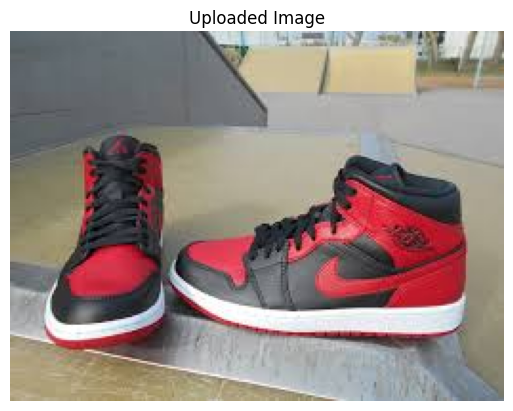

🗑️ Predicted Subcategory: shoes
♻️ Predicted Main Category: Textile Waste


In [10]:
# ======================================
# Shoes
# ======================================
import matplotlib.pyplot as plt

test_image_path = "shoes.jpg"  

image = Image.open(test_image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

input_image = predict_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = efficientnet_model(input_image)
    _, preds = torch.max(outputs, 1)

predicted_subcategory = class_names[preds.item()]
predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

print(f"🗑️ Predicted Subcategory: {predicted_subcategory}")
print(f"♻️ Predicted Main Category: {predicted_main_category}")

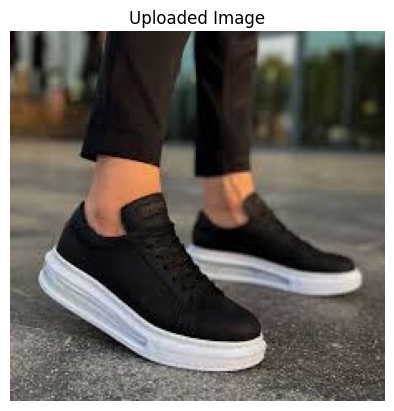

🗑️ Predicted Subcategory: shoes
♻️ Predicted Main Category: Textile Waste


In [11]:
# ======================================
# Shoes 2
# ======================================
import matplotlib.pyplot as plt

test_image_path = "shoes2.jpg"  

image = Image.open(test_image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

input_image = predict_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = efficientnet_model(input_image)
    _, preds = torch.max(outputs, 1)

predicted_subcategory = class_names[preds.item()]
predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

print(f"🗑️ Predicted Subcategory: {predicted_subcategory}")
print(f"♻️ Predicted Main Category: {predicted_main_category}")

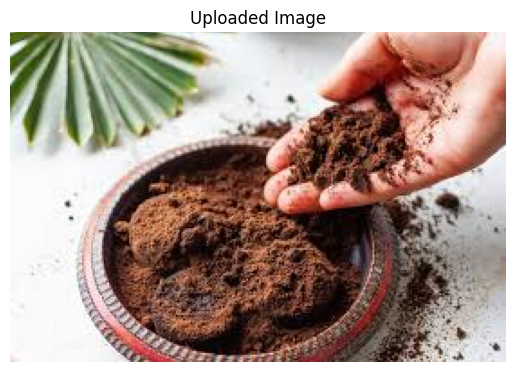

🗑️ Predicted Subcategory: coffee_grounds
♻️ Predicted Main Category: Food Waste


In [12]:
# ======================================
# Coffee Grounds
# ======================================
import matplotlib.pyplot as plt

test_image_path = "coffeegrounds.jpg"  

image = Image.open(test_image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

input_image = predict_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = efficientnet_model(input_image)
    _, preds = torch.max(outputs, 1)

predicted_subcategory = class_names[preds.item()]
predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

print(f"🗑️ Predicted Subcategory: {predicted_subcategory}")
print(f"♻️ Predicted Main Category: {predicted_main_category}")

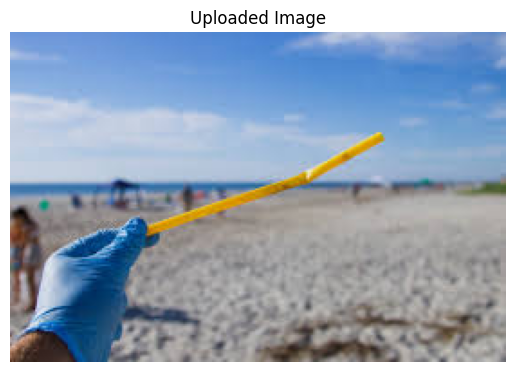

🗑️ Predicted Subcategory: plastic_straws
♻️ Predicted Main Category: Plastic
🔍 Prediction Confidence: 0.98


In [13]:
# ======================================
# Plastic Straws
# ======================================
import torch.nn.functional as F
import matplotlib.pyplot as plt

test_image_path = "plasticstraws.jpg"  

image = Image.open(test_image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

input_image = predict_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = efficientnet_model(input_image)
    probs = F.softmax(outputs, dim=1)  
    top_prob, preds = probs.topk(1, dim=1)  

top_prob = top_prob.item()
predicted_idx = preds.item()

predicted_subcategory = class_names[predicted_idx]
predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

confidence_threshold = 0.6 
if top_prob < confidence_threshold:
    predicted_subcategory = "Other"
    predicted_main_category = "Other"

print(f"🗑️ Predicted Subcategory: {predicted_subcategory}")
print(f"♻️ Predicted Main Category: {predicted_main_category}")
print(f"🔍 Prediction Confidence: {top_prob:.2f}")


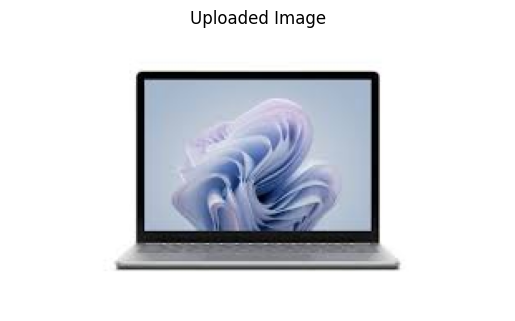

🗑️ Predicted Subcategory: Other
♻️ Predicted Main Category: Other
🔍 Prediction Confidence: 0.15


In [14]:
# ======================================
# 🚀 Laptop Image Classification (with "Other" category detection)
# ======================================
import torch.nn.functional as F
import matplotlib.pyplot as plt

test_image_path = "laptop.jpg"  

image = Image.open(test_image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

input_image = predict_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = efficientnet_model(input_image)
    probs = F.softmax(outputs, dim=1)  
    top_prob, preds = probs.topk(1, dim=1)  

top_prob = top_prob.item()
predicted_idx = preds.item()

predicted_subcategory = class_names[predicted_idx]
predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

confidence_threshold = 0.6  
if top_prob < confidence_threshold:
    predicted_subcategory = "Other"
    predicted_main_category = "Other"

print(f"🗑️ Predicted Subcategory: {predicted_subcategory}")
print(f"♻️ Predicted Main Category: {predicted_main_category}")
print(f"🔍 Prediction Confidence: {top_prob:.2f}")


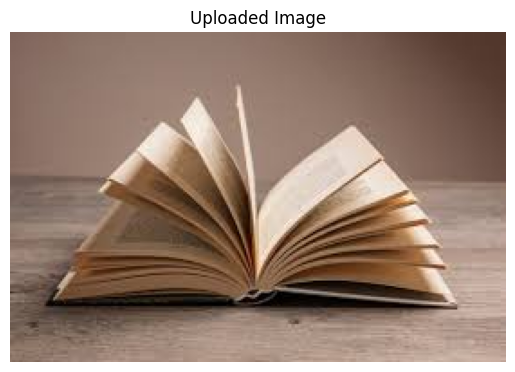

🗑️ Predicted Subcategory: Other
♻️ Predicted Main Category: Other
🔍 Prediction Confidence: 0.32


In [15]:
# ======================================
# Book
# ======================================
import torch.nn.functional as F
import matplotlib.pyplot as plt

test_image_path = "book.jpg"  

image = Image.open(test_image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

input_image = predict_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = efficientnet_model(input_image)
    probs = F.softmax(outputs, dim=1)  
    top_prob, preds = probs.topk(1, dim=1)  

top_prob = top_prob.item()
predicted_idx = preds.item()

predicted_subcategory = class_names[predicted_idx]
predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Unknown")

confidence_threshold = 0.6  
if top_prob < confidence_threshold:
    predicted_subcategory = "Other"
    predicted_main_category = "Other"

print(f"🗑️ Predicted Subcategory: {predicted_subcategory}")
print(f"♻️ Predicted Main Category: {predicted_main_category}")
print(f"🔍 Prediction Confidence: {top_prob:.2f}")


In [30]:
!pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.5 MB/s eta 0:00:00


/Users/sylviakozub/anaconda3/envs/ann2025/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


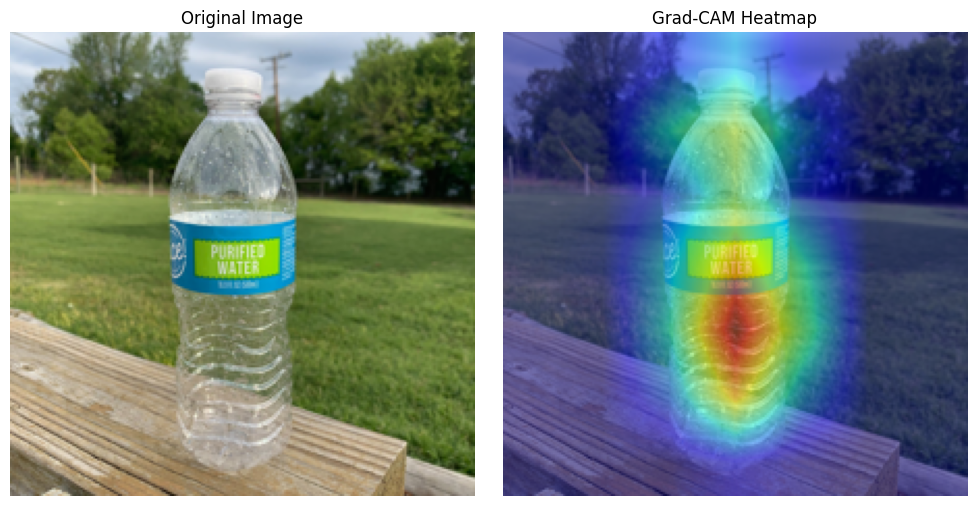

In [16]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import LayerGradCam

# Step 1: Load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_image = predict_transform(image).unsqueeze(0).to(device)
    return image, input_image

# Step 2: Generate Grad-CAM
def generate_gradcam(model, image_tensor, target_layer, class_idx=None):
    model.eval()
    gradcam = LayerGradCam(model, target_layer)

    if class_idx is None:
        outputs = model(image_tensor)
        class_idx = outputs.argmax(dim=1).item()

    attributions = gradcam.attribute(image_tensor, target=class_idx)

    # Upsample to input size
    upsampled_attr = torch.nn.functional.interpolate(attributions, size=(224, 224), mode="bilinear")

    return upsampled_attr.squeeze(0).squeeze(0).detach().cpu().numpy()

# Step 3: Plot Side-by-Side: Original + Heatmap
def plot_gradcam_side_by_side(original_image, heatmap):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axs[0].imshow(original_image.resize((224, 224)))
    axs[0].axis('off')
    axs[0].set_title("Original Image")

    # Heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()

    axs[1].imshow(original_image.resize((224, 224)))
    axs[1].imshow(heatmap, cmap='jet', alpha=0.5)  
    axs[1].axis('off')
    axs[1].set_title("Grad-CAM Heatmap")

    plt.tight_layout()
    plt.show()

# Step 4: Full Grad-CAM Pipeline
def run_gradcam_pipeline(image_path):
    original_image, image_tensor = load_image(image_path)

    target_layer = efficientnet_model.features[-1]

    heatmap = generate_gradcam(efficientnet_model, image_tensor, target_layer)
    plot_gradcam_side_by_side(original_image, heatmap)

run_gradcam_pipeline("waterbottle.jpg") 


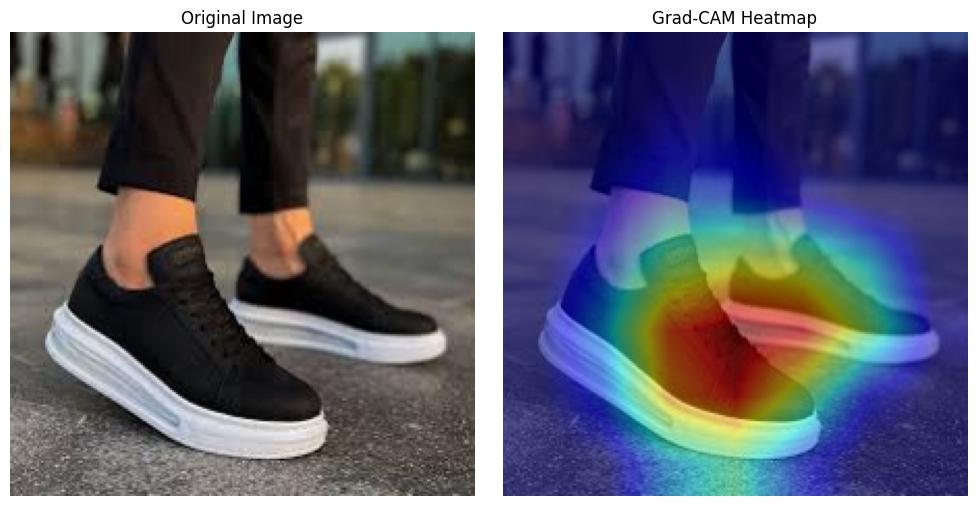

In [33]:
run_gradcam_pipeline("shoes2.jpg")

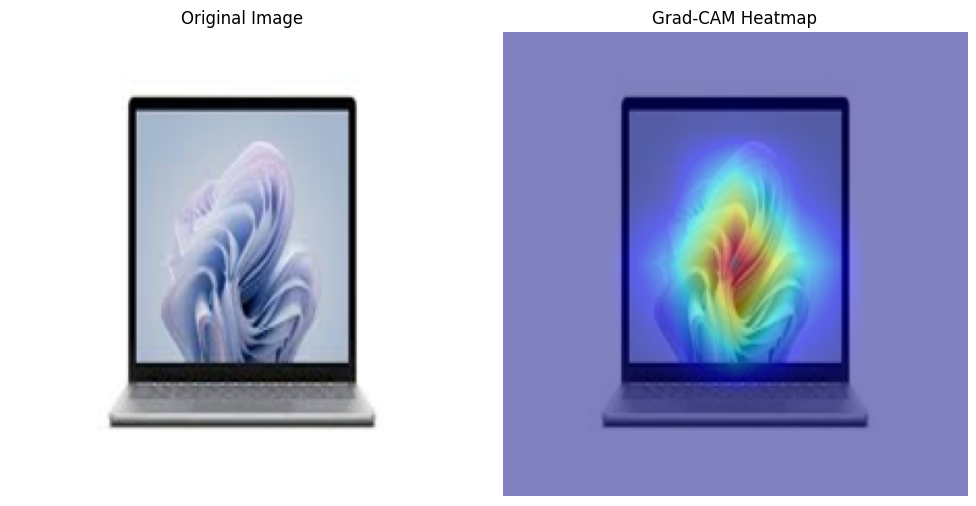

In [34]:
run_gradcam_pipeline("laptop.jpg")

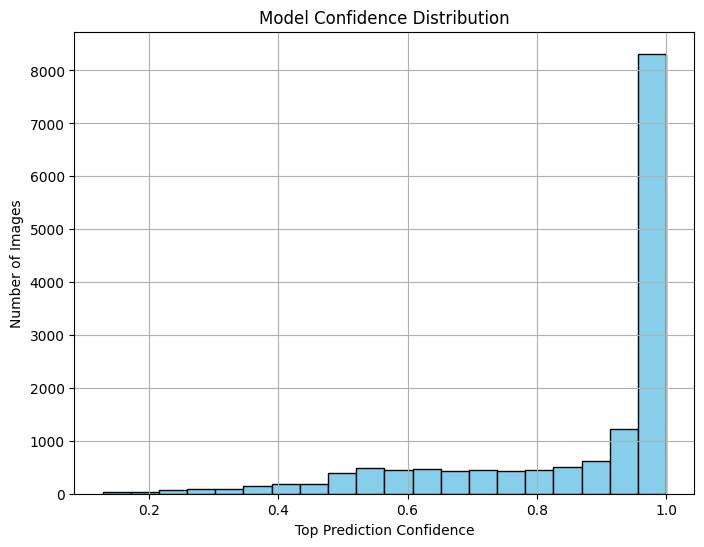

✅ Average Confidence: 0.86


In [36]:
import os
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# ======================================
#  Confidence Histogram from Dataset (Handles /default/ /real_world/)
# ======================================

images_folder = "images" 
confidences = []

for category in os.listdir(images_folder):
    category_path = os.path.join(images_folder, category)
    if os.path.isdir(category_path):
        for subfolder in os.listdir(category_path):  # (default / real_world)
            subfolder_path = os.path.join(category_path, subfolder)
            if os.path.isdir(subfolder_path):
                for filename in os.listdir(subfolder_path):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(subfolder_path, filename)

                        try:
                            # Load and preprocess
                            image = Image.open(image_path).convert('RGB')
                            input_image = predict_transform(image).unsqueeze(0).to(device)

                            with torch.no_grad():
                                outputs = efficientnet_model(input_image)
                                probs = F.softmax(outputs, dim=1)
                                top_prob = probs.max().item()

                            confidences.append(top_prob)
                        except Exception as e:
                            print(f"❌ Failed on image {image_path}: {e}")

if len(confidences) > 0:
    plt.figure(figsize=(8,6))
    plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
    plt.title('Model Confidence Distribution')
    plt.xlabel('Top Prediction Confidence')
    plt.ylabel('Number of Images')
    plt.grid(True)
    plt.show()

    avg_confidence = sum(confidences) / len(confidences)
    print(f"✅ Average Confidence: {avg_confidence:.2f}")

else:
    print("⚠️ No images were found or processed. Please check your 'images/' folder structure.")


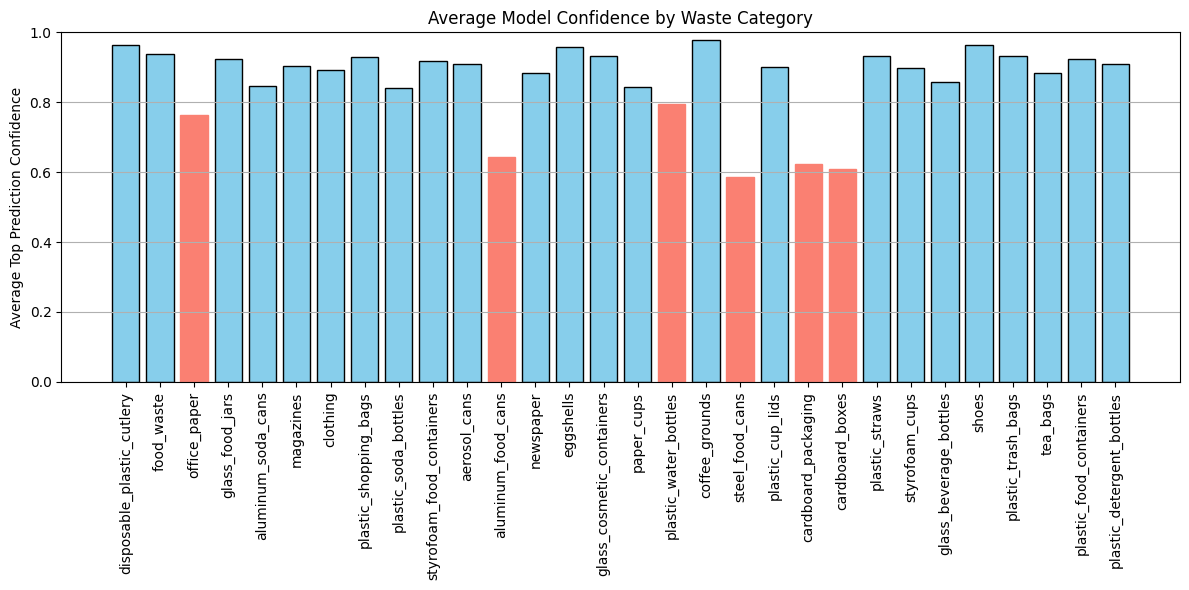

In [37]:
import os
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# ======================================
#  Average Confidence by Waste Category
# ======================================

images_folder = "images" 
category_confidences = defaultdict(list)

for category in os.listdir(images_folder):
    category_path = os.path.join(images_folder, category)
    if os.path.isdir(category_path):
        for subfolder in os.listdir(category_path):  # (default / real_world)
            subfolder_path = os.path.join(category_path, subfolder)
            if os.path.isdir(subfolder_path):
                for filename in os.listdir(subfolder_path):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(subfolder_path, filename)

                        try:
                            # Load and preprocess
                            image = Image.open(image_path).convert('RGB')
                            input_image = predict_transform(image).unsqueeze(0).to(device)

                            with torch.no_grad():
                                outputs = efficientnet_model(input_image)
                                probs = F.softmax(outputs, dim=1)
                                top_prob = probs.max().item()

                            # Save confidence into correct category
                            category_confidences[category].append(top_prob)
                        except Exception as e:
                            print(f"❌ Failed on image {image_path}: {e}")

categories = []
avg_confidences = []

for cat, probs in category_confidences.items():
    if probs:
        categories.append(cat)
        avg_confidences.append(np.mean(probs))

# Step 4: Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(categories, avg_confidences, color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.ylim(0, 1.0)
plt.title('Average Model Confidence by Waste Category')
plt.ylabel('Average Top Prediction Confidence')
plt.grid(axis='y')
plt.tight_layout()

for bar, confidence in zip(bars, avg_confidences):
    if confidence < 0.8:
        bar.set_color('salmon')  

plt.show()


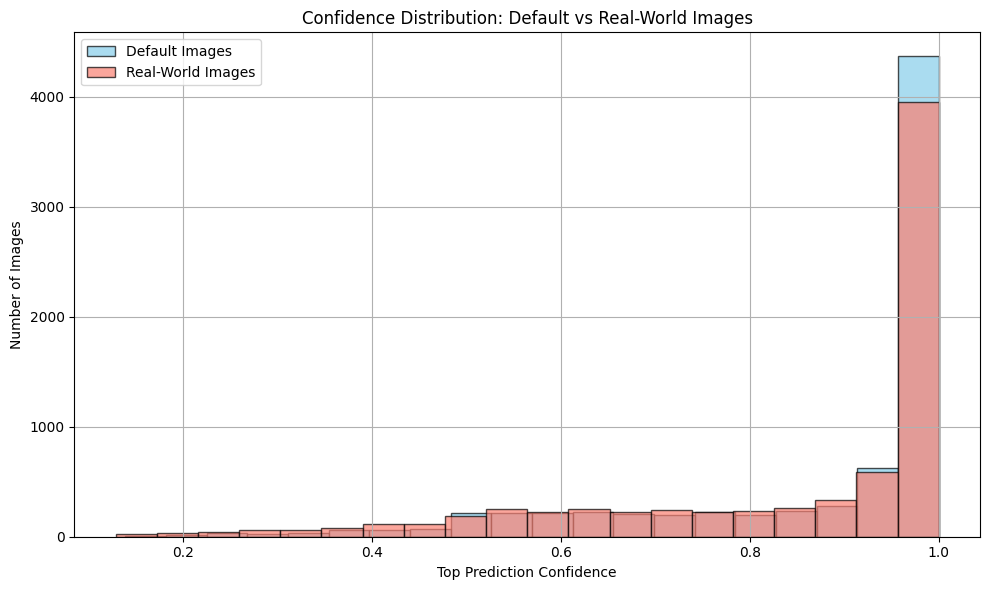

🏢 Average Confidence (Default Images): 0.88
🌳 Average Confidence (Real-World Images): 0.85


In [38]:
import os
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ======================================
# Confidence Comparison: Default vs Real-World
# ======================================

images_folder = "images"
default_confidences = []
realworld_confidences = []

for category in os.listdir(images_folder):
    category_path = os.path.join(images_folder, category)
    if os.path.isdir(category_path):
        for subfolder in os.listdir(category_path):  # (default / real_world)
            subfolder_path = os.path.join(category_path, subfolder)
            if os.path.isdir(subfolder_path):
                for filename in os.listdir(subfolder_path):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(subfolder_path, filename)

                        try:
                            # Load and preprocess
                            image = Image.open(image_path).convert('RGB')
                            input_image = predict_transform(image).unsqueeze(0).to(device)

                            with torch.no_grad():
                                outputs = efficientnet_model(input_image)
                                probs = F.softmax(outputs, dim=1)
                                top_prob = probs.max().item()

                            # Save to correct list
                            if "default" in subfolder.lower():
                                default_confidences.append(top_prob)
                            elif "real_world" in subfolder.lower():
                                realworld_confidences.append(top_prob)
                        except Exception as e:
                            print(f"❌ Failed on image {image_path}: {e}")

plt.figure(figsize=(10,6))
plt.hist(default_confidences, bins=20, alpha=0.7, label='Default Images', color='skyblue', edgecolor='black')
plt.hist(realworld_confidences, bins=20, alpha=0.7, label='Real-World Images', color='salmon', edgecolor='black')
plt.title('Confidence Distribution: Default vs Real-World Images')
plt.xlabel('Top Prediction Confidence')
plt.ylabel('Number of Images')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if len(default_confidences) > 0:
    avg_default = sum(default_confidences) / len(default_confidences)
    print(f"🏢 Average Confidence (Default Images): {avg_default:.2f}")

if len(realworld_confidences) > 0:
    avg_realworld = sum(realworld_confidences) / len(realworld_confidences)
    print(f"🌳 Average Confidence (Real-World Images): {avg_realworld:.2f}")


In [6]:
import cv2
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ======================================
# Live Webcam Prediction
# ======================================

# helper function to preprocess webcam frame
def preprocess_frame(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
    image = Image.fromarray(image)
    image = predict_transform(image).unsqueeze(0).to(device)
    return image

def predict_frame(model, input_tensor):
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        top_prob, preds = torch.max(probs, 1)
    predicted_subcategory = class_names[preds.item()]
    predicted_main_category = subcategory_to_main_category.get(predicted_subcategory, "Other")
    return predicted_subcategory, predicted_main_category, top_prob.item()

# open webcam
cap = cv2.VideoCapture(0)  # 0 = default webcam

print(" Press 'q' to quit the live stream!")

while True:
    ret, frame = cap.read()
    if not ret:
        print(" Failed to grab frame")
        break

    # preprocess frame
    input_tensor = preprocess_frame(frame)

    # predict
    predicted_subcategory, predicted_main_category, confidence = predict_frame(efficientnet_model, input_tensor)

    text = f"{predicted_subcategory} ({confidence*100:.1f}%)"
    frame = cv2.putText(frame, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # show frame
    cv2.imshow('Live Waste Classification', frame)

    # break on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
cv2.destroyAllWindows()


 Press 'q' to quit the live stream!
